<a href="https://colab.research.google.com/github/ga96jul/ML_COMM_Project/blob/master/EM_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt






In [0]:
def ask_cstll(M):
    # returns an M-QAM constellation as an
    # array of dimension Mx1
    
    X = np.arange(-M+1,M,2,dtype=int)
    
    X = X.reshape((1,X.size))
    X = X/np.sqrt(np.mean(X**2))
    
    return X

def qam_cstll(M):
    # returns an M-QAM constellation as an
    # array of dimension Mx1
    
    M_ask = int(np.sqrt(M))
    tmp = ask_cstll(M_ask).reshape((M_ask,1))
   
    tmp = tmp + 1j*tmp.T
    X = tmp.flatten()
    X = X/np.sqrt(np.mean(np.abs(X)**2))
    
    return X

In [0]:
data = np.load('EM_data.npy')

M = 16
N = data.size
C0 = 0
#C0 = np.random.randint(-7, 7, M) + 1j * np.random.randint(-7,7, M)
cnt_iter = 0

iter = 10000



# create M-QAM constellation
#C0 = np.array([1+1j,1-1j,1+3j,1+5j,1+7j,1-3j,1-5j,1-7j,-1+1j,-1+3j,-1+5j,-1+7j,-1-1j,-1-3j,-1-5j,-1-7j,3+1j,3+3j,3+5j,3+7j,3-1j,3-3j,3-5j,3-7j,5+1j,5+3j,5+5j,5+7j,5-1j,5-3j,5-5j,5-7j,7+1j,7+3j,7+5j,7+7j,7-1j,7-3j,7-5j,7-7j,-3+1j,-3+3j,-3+5j,-3+7j,-3-1j,-3-3j,-3-5j,-3-7j,-5+1j,-5+3j,-5+5j,-5+7j,-5-1j,-5-3j,-5-5j,-5-7j,-7+1j,-7+3j,-7+5j,-7+7j,-7-1j,-7-3j,-7-5j,-7-7j])    

C0 = 7 * qam_cstll(M)
QAM_64 = C0
K = C0.size
C = C0
while cnt_iter < iter:
    tmp = np.abs(data.reshape((N,1)) - C.reshape((1,K)))
    tmp_idx = np.argmin(tmp,axis=1)

    for j in range(K):
        idx = (tmp_idx == j)
        # check here: do we assign at least one point? if not, keep the old center
        if np.sum(idx) > 0:
            C[j] = np.sum(data[idx])/np.sum(idx)
    cnt_iter = cnt_iter + 1
    if cnt_iter%1000 == 0:
        progress = cnt_iter/iter * 100
        print("Progress:",progress)




Progress: 10.0
Progress: 20.0
Progress: 30.0
Progress: 40.0
Progress: 50.0
Progress: 60.0
Progress: 70.0
Progress: 80.0
Progress: 90.0
Progress: 100.0


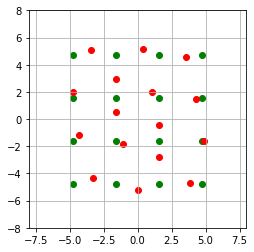

In [0]:
#plt.scatter(data.real,data.imag)
K = 5*qam_cstll(M)
plt.scatter(K.real,K.imag, color = "green")
#plt.scatter(QAM_64.real,QAM_64.imag, color = "green")
plt.scatter(C.real,C.imag, color = "red")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.draw()

In [0]:
def em(y, x_in, px_in, sigma2_in, iter):

    N = y.size
    px_out = px_in.reshape((1,px_in.size))
    x_out = x_in.reshape((1,x_in.size))
    sigma2_out = sigma2_in
    
    y = y.reshape((N,1))

    it = 0
    while it < iter:

        # E-Step: calculate the posterior distributions Q_X^i(x) for all samples y_i
        ###### FILL IN CODE HERE ########
        tmp =  scipy.stats.norm.pdf(y,x_out,np.sqrt(sigma2_out)) * px_out
        q_xy =  tmp / np.sum(tmp,axis=1).reshape(-1,1)
        #################################
        
        # M-step: maximization of the ELBO over the parameters; the following 
        # equations are the closed form expressions for the hereby obtained
        # stationary points

        ###### FILL IN CODE HERE ########
        px_out = np.sum(q_xy,axis=0)/N
        Delta = np.sum(np.sum(q_xy * x_out * y)) / np.sum(np.sum(q_xy * x_out**2))
        x_out = Delta*qam_cstll(16)
        sigma2_out = np.sum(np.sum(q_xy * (y-x_out)**2))/N  # use broadcasting here!
        #################################
        
        it = it + 1
        if it%50 == 0:
            progress = it/iter * 100
            print("Progress:",progress)    

    ###### FILL IN CODE HERE ########
    data_out = {'x':x_out,'sigma2':sigma2_out,'px':px_out,'Delta':Delta}
    #
    #################################
    
    return data_out

In [0]:
p0 = 1/M

# y = delta*x + N

sigma = 1
delta = 1

px = np.ones((1,M))/M

data_out = em(data, C, px,1+1j,400)
# y_distribution ~ N(delta*x,sigma)


Progress: 12.5
Progress: 25.0
Progress: 37.5
Progress: 50.0
Progress: 62.5
Progress: 75.0
Progress: 87.5
Progress: 100.0


Sigma2: 1.012-1.540j
Delta: 3.146-0.743j
P_X:
X


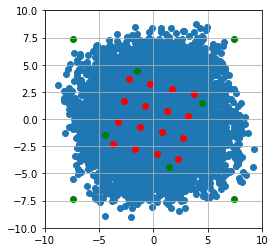

In [0]:
print("Sigma2: {:.3f}".format(data_out['sigma2']))
print("Delta: {:.3f}".format(data_out['Delta']))
print("P_X:".format(*data_out['px']))
print("X".format(*data_out['x']))
a = data_out['x']
c = data_out['Delta']*data_out['x']

plt.scatter(data.real,data.imag)
plt.scatter(a.real,a.imag, color ="red")
plt.scatter(c.real,c.imag, color="green")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.draw()

In [0]:

q_xy =  tmp / np.sum(tmp,axis=1).reshape(-1,1)
